In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib
import seaborn as sns
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors

import utils
import optimization
from social_learning import Network

font = {'size': 12}
matplotlib.rc('font', **font)

seed = 42
np.random.seed(seed)

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [3]:
step_size = 0.26
agents = 30
er_prob = 0.3
states = 2
adjacency_regime = 3 # 2 for FC, 3 for ER
multistate = True

np.random.seed(42)

clusters_agents = [15, 15]
agents = sum(clusters_agents)
clusters_states = [0, 1]
clusters = len(clusters_agents)
probs = 0.1 * np.ones((clusters, clusters))
probs[0,0] = 0.25
probs[1,1] = 0.25
g = nx.stochastic_block_model(clusters_agents, probs, seed=0)
adj_matrix = nx.adjacency_matrix(g).todense()
adj_matrix = np.array(adj_matrix)

combination_matrix, centrality, connected = utils.generate_combination_weights(adj_matrix, 0)
if not connected:
    raise (ValueError, "Not connected")

state_true = []
states_c = 2
state_size = [15, 15]
for s, c in zip(list(range(states_c)), state_size):
    state_true = state_true + c*[s]
state_true = np.array(state_true)

In [4]:
def plot_kls(pos, kls):
    n = len(kls)
    for p, kl in zip(list(range(n)), kls):
        x, y = pos[p]
        plt.text(x, y + 0.1, s=str(round(kl, 3)),
                 bbox=dict(facecolor='white', alpha=0.5),
                 horizontalalignment='center')

def plot_graph(combination_matrix, state_array, kls=None, color_map=None, seed=33):
    np.random.seed(seed)
    state_array = np.array(state_array)

    colors = sns.color_palette("tab10")
    colors_dark = sns.color_palette("dark")
    font = {'size': 17}
    matplotlib.rc('font', **font)

    combination_matrix_ = combination_matrix + combination_matrix.T
    adj_matrix = combination_matrix + combination_matrix.T
    adj_matrix[adj_matrix > 0] = 1

    pos = nx.spring_layout(nx.from_numpy_array(adj_matrix))
    G = nx.from_numpy_array(combination_matrix_)
    edges = G.edges()
    weights = [G[u][v]['weight']*5 for u, v in edges]

    plt.figure(figsize=(8, 7))
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[-2], node_size=350)
    nodes.set_edgecolor('black')
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors[0], node_size=350,
                           nodelist=np.where(state_array==1)[0])
    nodes.set_edgecolor('black')
    nx.draw_networkx_edges(G, pos=pos, edge_color='black', width=weights)
    
    if kls is not None:
        plot_kls(pos, kls)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


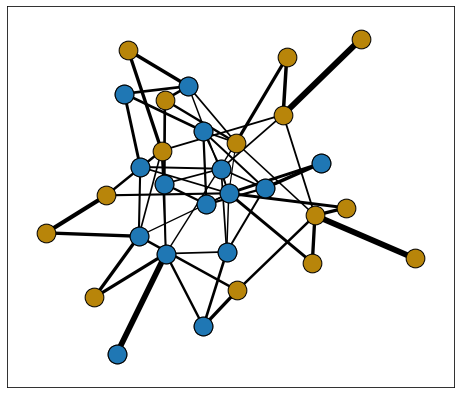

In [5]:
plot_graph(combination_matrix, state_true)

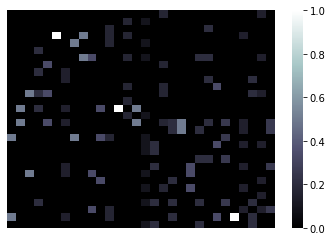

In [6]:
plt.figure()
sns.heatmap(combination_matrix, yticklabels=False, xticklabels=False, cbar=True,
            cmap=sns.color_palette("bone", as_cmap=True))
plt.show()

In [7]:
params=2
likelihood = np.array([
    [[1-0.1, 0.1], [1-0.5, 0.5]]
])
likelihood = np.repeat(likelihood, agents, 0) # agents, states, params

In [8]:
kl = utils.kl_divergence(likelihood, 0, 1, option=0, state_true=state_true)
d0, d1 = kl[0], -kl[-1]
d0, d1

(0.3680642071684971, 0.5108256237659907)

In [9]:
p0 = probs[0, 0]
q = probs[0, 1]

max((d1-d0)/d0, (d0-d1)/d1) * q/(p0-q)

0.25858063858975655

In [10]:
initial_belief = np.ones((states, agents))
initial_belief = initial_belief / initial_belief.sum(0)[None, :]
generator = utils.Generator(likelihood, state_true, 0)

In [11]:
times = 40000
times_skip = 100
lr = 0.01
window = 500
state_0 = 0
state_1 = 1

network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                  initial_belief, step_size=step_size, window=window+1)
network.step()
#stabilise

if times_skip > 0:
    for _ in range(times_skip):
        network.step()
    network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator,
                      network.belief_history[-1], step_size=step_size)
    network.step()

In [12]:
for step in range(times):
    network.step()

In [13]:
# mean based on one
int_beliefs = [network.intermediate_belief_history[i] for i in range(-500, -1)]
state_estimate_psi_ = [utils.state_estimate_psi(int_belief) for int_belief in int_beliefs]
state_estimate_psi_ = np.array(state_estimate_psi_)
state_estimate_psi = []
for ag in range(state_estimate_psi_.shape[1]):
    values, counts = np.unique(state_estimate_psi_[:,ag], return_counts=True)
    state = values[np.argmax(counts)]
    state_estimate_psi.append(state)
np.array(state_estimate_psi) == np.array(state_true)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [14]:
mc_estimation = np.array([network.intermediate_belief_history[i] for i in range(-500, -1)])
mc_estimation = mc_estimation[:500,state_true,np.arange(agents)]
mc_estimation[mc_estimation >= 0.5] = 1
mc_estimation[mc_estimation < 0.5] = 0
mc_estimation = mc_estimation.mean(0)
mc_estimation = 1 - mc_estimation

In [15]:
mc_estimation

array([0.63326653, 0.30861723, 0.37274549, 0.12825651, 0.25450902,
       0.2004008 , 0.24849699, 0.3747495 , 0.14629259, 0.40881764,
       0.37875752, 0.23246493, 0.2244489 , 0.11623246, 0.28056112,
       0.27054108, 0.09018036, 0.36272545, 0.12224449, 0.13627255,
       0.12024048, 0.15430862, 0.37875752, 0.24849699, 0.14629259,
       0.26052104, 0.19038076, 0.28256513, 0.30460922, 0.11422846])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


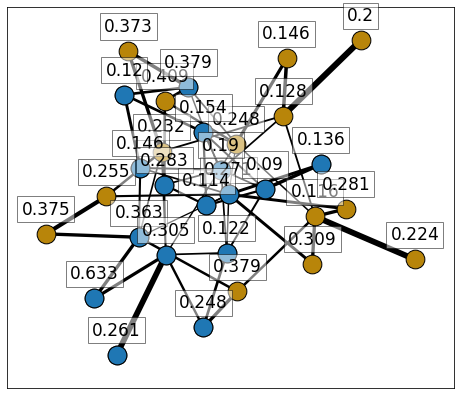

In [16]:
plot_graph(combination_matrix, state_estimate_psi, mc_estimation)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


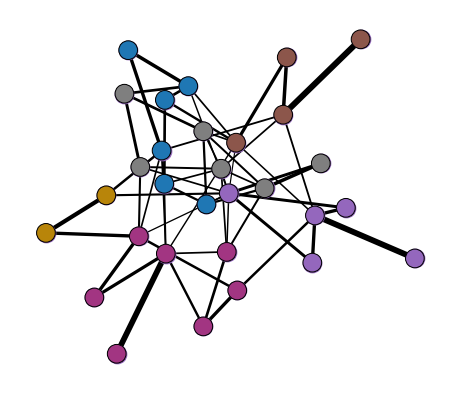

In [17]:
import community.community_louvain as louvain

font = {'size': 12}
matplotlib.rc('font', **font)

colors = sns.color_palette("tab10")
colors_dark = sns.color_palette("dark")

combination_matrix_ = combination_matrix + combination_matrix.T
adj_matrix = combination_matrix + combination_matrix.T
adj_matrix[adj_matrix > 0] = 1

np.random.seed(33)

pos = nx.spring_layout(nx.from_numpy_array(adj_matrix))
G = nx.from_numpy_array(combination_matrix_)
edges = G.edges()
weights = [G[u][v]['weight']*5 for u, v in edges]

part = louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

colors_dict = {0: colors_dark[-2], 1: colors[4], 2: colors[-3], 3: colors[5], 
               4: colors_dark[6], 5: colors[0]}
color_map = [colors_dict[part.get(node)] for node in G.nodes()]

plt.figure(figsize=(8, 7))
nx.draw_networkx_nodes(G, pos=pos, node_color=colors[4], node_size=350)

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=color_map, node_size=350)
nodes.set_edgecolor('black')
nx.draw_networkx_edges(G, pos=pos, edge_color='black', width=weights)
plt.box(False)